# Late Fusion
## Modality 4: Biometrics

## Setup

In [1]:
import os
from glob import glob
from pathlib import Path
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn as sk
import pickle
import copy

from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

### Paths

In [2]:
input_path = '../../../2_data_preprocessing/output/'

output_path = '../output/'

# Global configuration path
glob_conf_path = '../../../config/global_config_paper.py'

### Load global variables

In [3]:
exec(open(glob_conf_path).read())

### Load and shuffle data

In [4]:
train_df = pd.read_csv(os.path.join(input_path, 'train_m4_norm_df.csv'))

In [5]:
train_df

,glucose_value,hba1c_value,albumin_value,hdl_chol_value,ldl_chol_value,creatinine_value,insulin_value,trig_value,days_intense_phy_act,days_moderate_phy_act,days_walking,hemoglobin_value,minutes_sitting,BMI_random_adult,av_waist,av_systolic_bp,av_dyastolic_bp,label,group
0,0.092044,0.059259,0.059952,0.448598,0.245095,0.006153,0.020946,0.277143,0.000000,0.000000,0.428571,0.547771,0.249218,0.365607,0.370712,0.058442,0.380,0.0,5
1,0.092044,0.111111,0.064748,0.280374,0.294978,0.008299,0.092813,0.480000,0.000000,0.000000,1.000000,0.681529,0.186653,0.398685,0.567282,0.275974,0.560,0.0,3
2,0.148206,0.148148,0.069544,0.149533,0.328234,0.008585,0.012640,0.542857,0.000000,0.857143,1.000000,0.630573,0.186653,0.121826,0.241425,0.220779,0.768,1.0,2
3,0.148206,0.148148,0.069544,0.149533,0.328234,0.008585,0.012640,0.542857,0.000000,0.857143,1.000000,0.630573,0.186653,0.121826,0.241425,0.220779,0.768,0.0,2
4,0.104524,0.111111,0.062350,0.224299,0.191886,0.008585,0.098230,0.231429,0.142857,1.000000,0.571429,0.528662,0.061522,0.318299,0.355761,0.334416,0.572,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4414,0.141966,0.088889,0.076739,0.364486,0.308281,0.007154,0.091730,0.525714,0.000000,0.000000,1.000000,0.554140,0.124088,0.217887,0.243184,0.448052,0.668,0.0,2
4415,0.082683,0.081481,0.069544,0.280374,0.225141,0.006009,0.083785,0.565714,0.000000,1.000000,0.714286,0.585987,0.124088,0.266402,0.322339,0.262987,0.572,0.0,3
4416,0.082683,0.081481,0.069544,0.280374,0.225141,0.006009,0.083785,0.565714,0.000000,1.000000,0.714286,0.585987,0.124088,0.266402,0.322339,0.262987,0.572,0.0,2
4417,0.115445,0.059259,0.067146,0.719626,0.138676,0.007726,0.050199,0.585714,0.142857,1.000000,1.000000,0.681529,0.030240,0.102790,0.156113,0.363636,0.480,1.0,3


In [6]:
from sklearn.utils import shuffle

train_shuffled_df = shuffle(train_df, random_state=seed).reset_index(drop=True)

In [7]:
train_shuffled_df

,glucose_value,hba1c_value,albumin_value,hdl_chol_value,ldl_chol_value,creatinine_value,insulin_value,trig_value,days_intense_phy_act,days_moderate_phy_act,days_walking,hemoglobin_value,minutes_sitting,BMI_random_adult,av_waist,av_systolic_bp,av_dyastolic_bp,label,group
0,0.271451,0.622222,0.050360,0.383178,0.381443,0.004436,0.023835,0.260000,0.000000,0.000000,0.000000,0.611465,0.061522,0.224454,0.281882,0.409091,0.636,0.0,3
1,0.154446,0.185185,0.071942,0.168224,0.211839,0.005151,0.020946,0.580000,0.000000,1.000000,0.428571,0.528662,0.124088,0.318472,0.366755,0.129870,0.488,1.0,4
2,0.123245,0.074074,0.062350,0.299065,0.271699,0.009014,0.032864,0.482857,0.000000,0.000000,1.000000,0.579618,0.374348,0.337019,0.514512,0.392857,0.704,0.0,1
3,0.098284,0.103704,0.067146,0.168224,0.000000,0.004722,0.011918,0.388571,0.000000,0.000000,1.000000,0.560510,0.030240,0.119850,0.143360,0.344156,0.600,0.0,1
4,0.107644,0.103704,0.055156,0.364486,0.125374,0.006153,0.065367,0.611429,0.000000,1.000000,0.285714,0.254777,0.249218,0.468413,0.489886,0.178571,0.464,1.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4414,0.104524,0.103704,0.074341,0.214953,0.285002,0.005723,0.065005,0.520000,0.000000,1.000000,0.571429,0.687898,0.749739,0.360497,0.312225,0.214286,0.588,1.0,5
4415,0.307332,0.429630,0.059952,0.280374,0.454606,0.004722,0.020946,0.280000,0.000000,0.285714,0.714286,0.509554,0.061522,0.240632,0.317942,0.532468,0.676,1.0,3
4416,0.138846,0.096296,0.083933,0.327103,0.228467,0.015024,0.031058,0.628571,1.000000,0.142857,1.000000,0.605096,0.249218,0.283237,0.437555,0.422078,0.764,1.0,2
4417,0.113885,0.088889,0.069544,0.336449,0.231792,0.008442,0.027447,0.540000,0.000000,1.000000,1.000000,0.707006,0.061522,0.376893,0.411609,0.266234,0.580,0.0,5


## Other functions

In [8]:
from sklearn.metrics import confusion_matrix
    
def plot_save_conf_matrix(X, y, cv, clf, title, file_name, report=False):
    
    # Initialize some variables to store results
    conf_mat_avg = np.zeros([2,2])
    n_groups = 0
    for train_idx, val_idx in cv:
        n_groups += 1
        X_train, X_val, y_train, y_val = X.iloc[train_idx], X.iloc[val_idx], y.iloc[train_idx], y.iloc[val_idx]
        
        clf.fit(X_train,y_train)
        
        # Compute results (validation dataset)    
        y_pred = clf.predict(X_val)                       # Predict class
        conf_mat_tmp = confusion_matrix(y_val,            # Compute confusion matrix for this batch
                                        y_pred,
                                        normalize='true'
                                       )
        conf_mat_avg += conf_mat_tmp
    
    conf_mat_avg /= n_groups
    
    
    df_cm = pd.DataFrame(conf_mat_avg, list(label_id_to_label_num.keys()), list(label_id_to_label_num.keys()))
    df_cm = df_cm.reindex(sorted(df_cm.columns)).reindex(sorted(df_cm.columns), axis=1)
    
    plt.figure(figsize=(5,5))
    ax = sns.heatmap(df_cm, annot=True, fmt='.2f', vmin=0, vmax=1, cmap=conf_cmap)
    plt.yticks(va='center')
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    if report == True:
        plt.savefig(os.path.join(output_path,'confusion_matrix','report_'+file_name), bbox_inches = 'tight') 
    plt.title(title)
    plt.savefig(os.path.join(output_path,'confusion_matrix',file_name), bbox_inches = 'tight')        

## Elastic Net SGD Classifier

In [9]:
from sklearn.linear_model import SGDClassifier

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=['label','group'])
y = train_shuffled_df.label
groups = train_shuffled_df.group
n_groups = len(groups.unique())


# Define parameters to evaluate
alpha_values            = [0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.005, 0.0025, 0.0075, 0.01, 0.05, 0.1, 1]
n_iter_no_change_values = [20, 50, 100, 150]
l1_ratio_values         = [0.049, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50,
                           0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.89, 0.95, 0.99]
parameters              = {'penalty': ['elasticnet'],
                           'class_weight': ['balanced'],
                           'loss': ['log'],
                           'random_state': [seed],
                           'alpha': alpha_values,
                           'l1_ratio': l1_ratio_values,
                           'n_iter_no_change': n_iter_no_change_values,
                           'max_iter': [2500]
                          }

elasticnet = SGDClassifier()
logo = LeaveOneGroupOut()

clf = GridSearchCV(estimator  = elasticnet, 
                   param_grid = parameters,
                   scoring    = 'roc_auc_ovo_weighted',
                   cv         = logo.split(X=X,groups=groups),
                   verbose    = 1,
                   n_jobs     = -1,
                  )
clf.fit(X,y)
print(clf.best_estimator_)

# Store results in a DataFrame and then save them as csv
results_df = pd.DataFrame(clf.cv_results_)
results_df.to_csv(os.path.join(output_path,'results','res_elastic_net_'+str(n_groups)+'_logocv_m4.csv'), index=None, header=True)

# Save best parameters to disk
file_path = os.path.join(output_path,'best_params','best_params_elastic_net_m4.sav')
pickle.dump(clf.best_params_, open(file_path, 'wb'))

# Save the best model to disk
file_path = os.path.join(output_path,'models','mod_elastic_net_m4.sav')
pickle.dump(clf.best_estimator_, open(file_path, 'wb'))

Fitting 5 folds for each of 960 candidates, totalling 4800 fits
SGDClassifier(alpha=0.0005, class_weight='balanced', l1_ratio=0.99, loss='log',
              max_iter=2500, n_iter_no_change=20, penalty='elasticnet',
              random_state=27)


In [10]:
results_df.sort_values(by="rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_class_weight,param_l1_ratio,param_loss,param_max_iter,param_n_iter_no_change,...,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
236,0.097797,0.097633,0.003800,0.000400,0.0005,balanced,0.99,log,2500,20,...,27,"{'alpha': 0.0005, 'class_weight': 'balanced', ...",0.606379,0.636789,0.631392,0.630619,0.625288,0.626093,0.010509,1
220,0.116997,0.095692,0.003801,0.000402,0.0005,balanced,0.8,log,2500,20,...,27,"{'alpha': 0.0005, 'class_weight': 'balanced', ...",0.607152,0.637251,0.631367,0.630613,0.623500,0.625977,0.010375,2
224,0.140196,0.131312,0.004007,0.001095,0.0005,balanced,0.85,log,2500,20,...,27,"{'alpha': 0.0005, 'class_weight': 'balanced', ...",0.607223,0.636560,0.631492,0.630630,0.623977,0.625976,0.010196,3


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


AUC_avg (train): 0.6317403991492602
AUC_std (train): 0.0024960118802526705
AUC_avg (validation): 0.6260932972606035
AUC_std (validation): 0.01050943995702923
UAR_avg (train): 0.5893753465507304
UAR_std (train): 0.0037720739077104345
UAR_avg (validation): 0.5769696152216246
UAR_std (validation): 0.010954997003000991


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
c:\Users\rosar\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
c:\Users\rosar\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
c:\Users\rosar\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
c:\Users\rosar\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


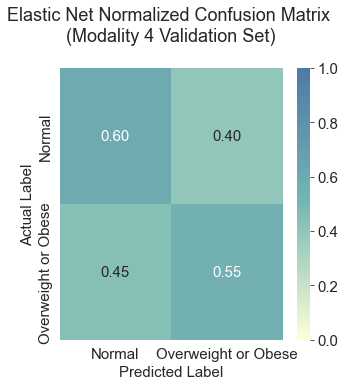

In [11]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_validate

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=['label','group'])
y = train_shuffled_df.label
groups = train_shuffled_df.group

logo = LeaveOneGroupOut()


# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_elastic_net_m4.sav')
best_params = pickle.load(open(file_path, 'rb'))
                   
clf = SGDClassifier(**best_params)

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['roc_auc_ovo_weighted'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('AUC_avg (train):', np.mean(scores['train_roc_auc_ovo_weighted']))
print('AUC_std (train):', np.std(scores['train_roc_auc_ovo_weighted']))
print('AUC_avg (validation):', np.mean(scores['test_roc_auc_ovo_weighted']))
print('AUC_std (validation):', np.std(scores['test_roc_auc_ovo_weighted']))

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['recall_macro'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('UAR_avg (train):', np.mean(scores['train_recall_macro']))
print('UAR_std (train):', np.std(scores['train_recall_macro']))
print('UAR_avg (validation):', np.mean(scores['test_recall_macro']))
print('UAR_std (validation):', np.std(scores['test_recall_macro']))

# Confusion matrix
plot_save_conf_matrix(X         = X,
                      y         = y,
                      cv        = logo.split(X=X,groups=groups),
                      clf       = clf,
                      title     = """Elastic Net Normalized Confusion Matrix 
(Modality 4 Validation Set)
""",
                      file_name = 'conf_mat_elastic_net_m4.svg',
                      report    = True 
                     )

## kNN Classifier

In [12]:
from sklearn.neighbors import KNeighborsClassifier

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=['label','group'])
y = train_shuffled_df.label
groups = train_shuffled_df.group
n_groups = len(groups.unique())


# Define parameters to evaluate
n_neigh_values   = np.arange(1, 905, 5).tolist()
leaf_size_values = [10, 20, 30]
algorithm_values = ['ball_tree','brute', 'kd_tree']
parameters      = {'n_neighbors': n_neigh_values,
                   'leaf_size': leaf_size_values,
                   'weights': ['uniform'],
                   'algorithm': algorithm_values,
                   'metric': ['manhattan'],
                   'n_jobs': [-1]
                  }

knn = KNeighborsClassifier()
logo = LeaveOneGroupOut()

clf = GridSearchCV(estimator  = knn, 
                   param_grid = parameters,
                   scoring    = 'roc_auc_ovo_weighted',
                   cv         = logo.split(X=X,groups=groups),
                   verbose    = 1,
                   n_jobs     = -1,
                  )
clf.fit(X,y)
print(clf.best_estimator_)

# Store results in a DataFrame and then save them as csv
results_df = pd.DataFrame(clf.cv_results_)
results_df.to_csv(os.path.join(output_path,'results','res_knn_'+str(n_groups)+'_logocv_m4.csv'), index=None, header=True)

# Save best parameters to disk
file_path = os.path.join(output_path,'best_params','best_params_knn_m4.sav')
pickle.dump(clf.best_params_, open(file_path, 'wb'))

# Save the best model to disk
file_path = os.path.join(output_path,'models','mod_knn_m4.sav')
pickle.dump(clf.best_estimator_, open(file_path, 'wb'))

Fitting 5 folds for each of 1629 candidates, totalling 8145 fits
KNeighborsClassifier(algorithm='kd_tree', metric='manhattan', n_jobs=-1,
                     n_neighbors=866)


In [13]:
results_df.sort_values(by="rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_leaf_size,param_metric,param_n_jobs,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1621,0.041996,0.023049,1.245320,0.076751,kd_tree,30,manhattan,-1,866,uniform,"{'algorithm': 'kd_tree', 'leaf_size': 30, 'met...",0.586675,0.626087,0.633204,0.598717,0.596133,0.608163,0.018133,1
535,0.025598,0.015472,1.306737,0.207346,ball_tree,30,manhattan,-1,866,uniform,"{'algorithm': 'ball_tree', 'leaf_size': 30, 'm...",0.586708,0.625925,0.633294,0.598438,0.596210,0.608115,0.018137,2
1078,0.004997,0.001551,1.192600,0.113554,brute,30,manhattan,-1,866,uniform,"{'algorithm': 'brute', 'leaf_size': 30, 'metri...",0.586520,0.626012,0.633329,0.598692,0.596020,0.608115,0.018207,3


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


AUC_avg (train): 0.6149236742655534
AUC_std (train): 0.005380747412913639
AUC_avg (validation): 0.6081633489026976
AUC_std (validation): 0.018132898921396717


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished
c:\Users\rosar\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


UAR_avg (train): 0.5007918665414766
UAR_std (train): 0.000957338220828196
UAR_avg (validation): 0.5004639724515092
UAR_std (validation): 0.0007440439642166675


c:\Users\rosar\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\Users\rosar\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\Users\rosar\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\Users\rosar\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


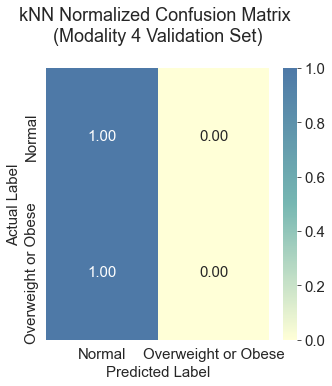

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=['label','group'])
y = train_shuffled_df.label
groups = train_shuffled_df.group

logo = LeaveOneGroupOut()


# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_knn_m4.sav')
best_params = pickle.load(open(file_path, 'rb'))
                   
clf = KNeighborsClassifier(**best_params)

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['roc_auc_ovo_weighted'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('AUC_avg (train):', np.mean(scores['train_roc_auc_ovo_weighted']))
print('AUC_std (train):', np.std(scores['train_roc_auc_ovo_weighted']))
print('AUC_avg (validation):', np.mean(scores['test_roc_auc_ovo_weighted']))
print('AUC_std (validation):', np.std(scores['test_roc_auc_ovo_weighted']))

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['recall_macro'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('UAR_avg (train):', np.mean(scores['train_recall_macro']))
print('UAR_std (train):', np.std(scores['train_recall_macro']))
print('UAR_avg (validation):', np.mean(scores['test_recall_macro']))
print('UAR_std (validation):', np.std(scores['test_recall_macro']))

# Confusion matrix
plot_save_conf_matrix(X         = X,
                      y         = y,
                      cv        = logo.split(X=X,groups=groups),
                      clf       = clf,
                      title     = """kNN Normalized Confusion Matrix 
(Modality 4 Validation Set)
""",
                      file_name = 'conf_mat_knn_m4.svg'
                     )

## Decision Tree

In [15]:
from sklearn.tree import DecisionTreeClassifier

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=['label','group'])
y = train_shuffled_df.label
groups = train_shuffled_df.group
n_groups = len(groups.unique())


# Define parameters to evaluate
criterion_values         = ['gini', 'entropy']
splitter_values          = ['best', 'random']
max_depth_values         = np.arange(5, 55, 5).tolist()
min_samples_split_values = np.linspace(0.1, 1.0, 10, endpoint=True)
min_samples_leaf_values  = np.linspace(0.1, 0.5, 5, endpoint=True)
max_features_values      = [int(x) for x in np.linspace(1, len(X.columns), num = 18)] #list(range(1,len(X.columns)))
parameters      = {'criterion': criterion_values,
                   'splitter': splitter_values,
                   'max_depth': max_depth_values,
                   'min_samples_split': min_samples_split_values,
                   'min_samples_leaf': min_samples_leaf_values,
                   'max_features': max_features_values,
                   'class_weight': ['balanced'],
                   'random_state': [seed]
                  }

dt = DecisionTreeClassifier()
logo = LeaveOneGroupOut()

# Reduce the number of possible combinations by randomly resampling to 5000 combinations
clf = RandomizedSearchCV(estimator           = dt, 
                         param_distributions = parameters,
                         scoring             = 'roc_auc_ovo_weighted',
                         cv                  = logo.split(X=X,groups=groups),
                         verbose             = 1,
                         random_state        = seed,
                         n_iter              = 5000,
                         n_jobs              = -1
                         )
clf.fit(X,y)
print(clf.best_estimator_)

# Store results in a DataFrame and then save them as csv
results_df = pd.DataFrame(clf.cv_results_)
results_df.to_csv(os.path.join(output_path,'results','res_tree_'+str(n_groups)+'_logocv_m4.csv'), index=None, header=True)

# Save best parameters to disk
file_path = os.path.join(output_path,'best_params','best_params_tree_m4.sav')
pickle.dump(clf.best_params_, open(file_path, 'wb'))

# Save the best model to disk
file_path = os.path.join(output_path,'models','mod_tree_m4.sav')
pickle.dump(clf.best_estimator_, open(file_path, 'wb'))

Fitting 5 folds for each of 5000 candidates, totalling 25000 fits
DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, max_features=14, min_samples_leaf=0.2,
                       min_samples_split=0.4, random_state=27)


In [16]:
results_df.sort_values(by="rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_splitter,param_random_state,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,...,param_class_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
858,0.015000,0.005021,0.0072,0.005912,best,27,0.4,0.2,14,10,...,balanced,"{'splitter': 'best', 'random_state': 27, 'min_...",0.586844,0.622468,0.626483,0.627676,0.632055,0.619105,0.016418,1
995,0.039799,0.028308,0.0162,0.019372,best,27,0.3,0.2,14,10,...,balanced,"{'splitter': 'best', 'random_state': 27, 'min_...",0.586844,0.622468,0.626483,0.627676,0.632055,0.619105,0.016418,1
2954,0.011400,0.000490,0.0038,0.000401,best,27,0.2,0.2,14,10,...,balanced,"{'splitter': 'best', 'random_state': 27, 'min_...",0.586844,0.622468,0.626483,0.627676,0.632055,0.619105,0.016418,1


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


AUC_avg (train): 0.6262458658317042
AUC_std (train): 0.00236781063382287
AUC_avg (validation): 0.6191052382900555
AUC_std (validation): 0.016417507318618282
UAR_avg (train): 0.5942302913627531
UAR_std (train): 0.002648802664703061
UAR_avg (validation): 0.5845956514578592
UAR_std (validation): 0.016733220396610887


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


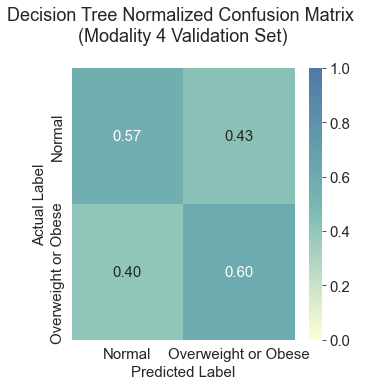

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=['label','group'])
y = train_shuffled_df.label
groups = train_shuffled_df.group

logo = LeaveOneGroupOut()


# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_tree_m4.sav')
best_params = pickle.load(open(file_path, 'rb'))
                   
clf = DecisionTreeClassifier(**best_params)

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['roc_auc_ovo_weighted'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('AUC_avg (train):', np.mean(scores['train_roc_auc_ovo_weighted']))
print('AUC_std (train):', np.std(scores['train_roc_auc_ovo_weighted']))
print('AUC_avg (validation):', np.mean(scores['test_roc_auc_ovo_weighted']))
print('AUC_std (validation):', np.std(scores['test_roc_auc_ovo_weighted']))

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['recall_macro'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('UAR_avg (train):', np.mean(scores['train_recall_macro']))
print('UAR_std (train):', np.std(scores['train_recall_macro']))
print('UAR_avg (validation):', np.mean(scores['test_recall_macro']))
print('UAR_std (validation):', np.std(scores['test_recall_macro']))

# Confusion matrix
plot_save_conf_matrix(X         = X,
                      y         = y,
                      cv        = logo.split(X=X,groups=groups),
                      clf       = clf,
                      title     = """Decision Tree Normalized Confusion Matrix 
(Modality 4 Validation Set)
""",
                      file_name = 'conf_mat_tree_m4.svg'
                     )

## Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=['label','group'])
y = train_shuffled_df.label
groups = train_shuffled_df.group
n_groups = len(groups.unique())


# Define parameters to evaluate
n_estimators_values      = [int(x) for x in np.linspace(10, 500, num = 100)]#np.arange(100, 810, 10).tolist()
criterion_values         = ['gini']
class_weight_values      = ['balanced']
max_features_values      = ['auto', 'sqrt']
max_depth_values         = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth_values.append(None)
min_samples_split_values = [2, 5, 10]
min_samples_leaf_values  = [1, 2, 4]
bootstrap_values         = [True, False]
parameters      = {'n_estimators': n_estimators_values,
                   'criterion': criterion_values,
                   'max_features': max_features_values,
                   'max_depth': max_depth_values,
                   'min_samples_split': min_samples_split_values,
                   'min_samples_leaf': min_samples_leaf_values,
                   'bootstrap': bootstrap_values,
                   'random_state': [seed],
                   'class_weight': class_weight_values,
                   'n_jobs': [-1]
                  }

rf = RandomForestClassifier()
logo = LeaveOneGroupOut()

# Reduce the number of possible combinations by randomly resampling to 5000 combinations
clf = RandomizedSearchCV(estimator           = rf, 
                         param_distributions = parameters,
                         scoring             = 'roc_auc_ovo_weighted',
                         cv                  = logo.split(X=X,groups=groups),
                         verbose             = 1,
                         n_iter              = 5000,
                         random_state        = seed,
                         n_jobs              = -1
                        )
clf.fit(X,y)
print(clf.best_estimator_)

# Store results in a DataFrame and then save them as csv
results_df = pd.DataFrame(clf.cv_results_)
results_df.to_csv(os.path.join(output_path,'results','res_rf_'+str(n_groups)+'_logocv_m4.csv'), index=None, header=True)

# Save best parameters to disk
file_path = os.path.join(output_path,'best_params','best_params_rf_m4.sav')
pickle.dump(clf.best_params_, open(file_path, 'wb'))

# Save the best model to disk
file_path = os.path.join(output_path,'models','mod_rf_m4.sav')
pickle.dump(clf.best_estimator_, open(file_path, 'wb'))

Fitting 5 folds for each of 5000 candidates, totalling 25000 fits
RandomForestClassifier(class_weight='balanced', max_depth=10,
                       max_features='sqrt', min_samples_leaf=4,
                       min_samples_split=10, n_estimators=326, n_jobs=-1,
                       random_state=27)


In [19]:
results_df.sort_values(by="rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_random_state,param_n_jobs,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,...,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4602,7.390462,0.274009,2.594213,0.658886,27,-1,326,10,4,sqrt,...,True,"{'random_state': 27, 'n_jobs': -1, 'n_estimato...",0.608138,0.649386,0.646340,0.639934,0.626434,0.634046,0.015168,1
2976,5.864881,1.887554,2.444504,1.134820,27,-1,321,10,4,sqrt,...,True,"{'random_state': 27, 'n_jobs': -1, 'n_estimato...",0.607860,0.649286,0.646140,0.640001,0.626812,0.634020,0.015179,2
1049,7.779338,1.628487,4.111031,0.164406,27,-1,356,10,4,sqrt,...,True,"{'random_state': 27, 'n_jobs': -1, 'n_estimato...",0.607414,0.649649,0.646754,0.637948,0.627344,0.633822,0.015324,3


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


AUC_avg (train): 0.937565925264162
AUC_std (train): 0.0042948040248914675
AUC_avg (validation): 0.6340463620663213
AUC_std (validation): 0.01516760332447762


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.2s finished


UAR_avg (train): 0.8594116051187564
UAR_std (train): 0.006659821788045716
UAR_avg (validation): 0.597885236300781
UAR_std (validation): 0.014916412719010591


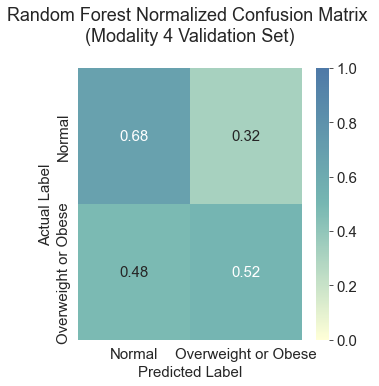

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=['label','group'])
y = train_shuffled_df.label
groups = train_shuffled_df.group

logo = LeaveOneGroupOut()


# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_rf_m4.sav')
best_params = pickle.load(open(file_path, 'rb'))
                   
clf = RandomForestClassifier(**best_params)

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['roc_auc_ovo_weighted'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('AUC_avg (train):', np.mean(scores['train_roc_auc_ovo_weighted']))
print('AUC_std (train):', np.std(scores['train_roc_auc_ovo_weighted']))
print('AUC_avg (validation):', np.mean(scores['test_roc_auc_ovo_weighted']))
print('AUC_std (validation):', np.std(scores['test_roc_auc_ovo_weighted']))

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['recall_macro'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('UAR_avg (train):', np.mean(scores['train_recall_macro']))
print('UAR_std (train):', np.std(scores['train_recall_macro']))
print('UAR_avg (validation):', np.mean(scores['test_recall_macro']))
print('UAR_std (validation):', np.std(scores['test_recall_macro']))

# Confusion matrix
plot_save_conf_matrix(X         = X,
                      y         = y,
                      cv        = logo.split(X=X,groups=groups),
                      clf       = clf,
                      title     = """Random Forest Normalized Confusion Matrix 
(Modality 4 Validation Set)
""",
                      file_name = 'conf_mat_rf_m4.svg'
                     )